In [8]:
from choice_model import ChoiceModel
import networkx as nx
model = ChoiceModel()
actors = [a for a in model.graph.nodes if model.graph.nodes[a]['type'] == 'Actors']
print("number of actors: ", len(actors))
print("number of nodes: ",len(model.graph.nodes()))
model.visualize()

number of actors:  403
number of nodes:  868


# View Specific Period

In [4]:
model.set_period(8)
model.visualize(model.graph)

# Roll Back

In [9]:
import pandas as pd
index_df = pd.DataFrame(columns=['period','PPI', 'CVI', 'DCI'])

In [10]:
for i in range(10):
    model.roll_back(i)
    index_df.loc[i] = [i] + list(model.evaluate())
    model.visualize(file_name=f"period_{i}.html")

index_df.head()

,period,PPI,CVI,DCI
0,0.0,0.324295,3.301887,0.908571
1,1.0,0.362038,3.980198,0.753731
2,2.0,0.344548,4.083333,0.734694
3,3.0,0.384506,4.483607,0.669104
4,4.0,0.401504,4.693431,0.639191


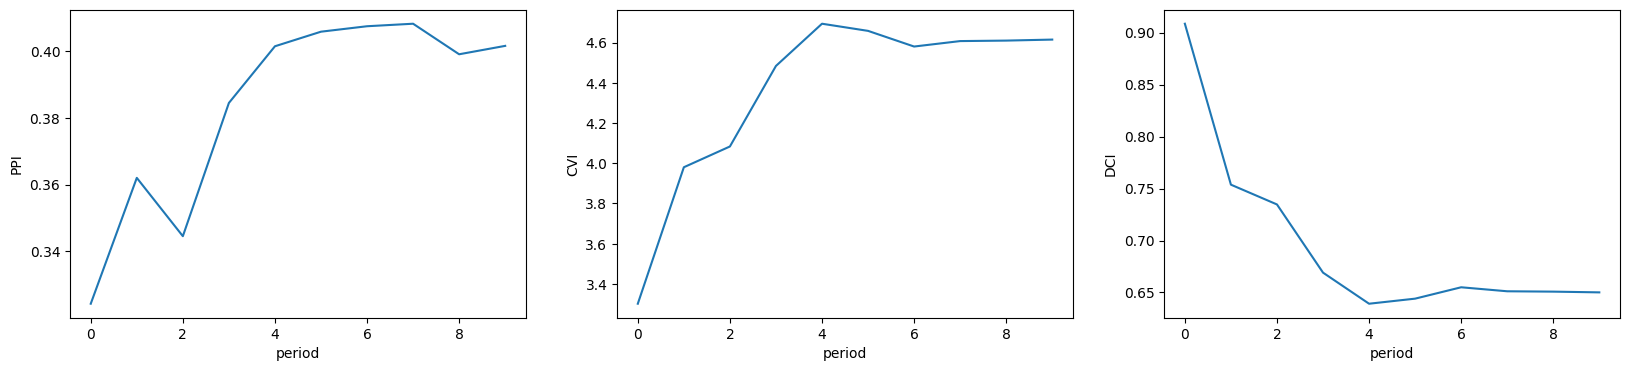

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,3, figsize=(20,4))

sns.lineplot(data=index_df, x='period', y='PPI', ax=ax[0])
sns.lineplot(data=index_df, x='period', y='CVI', ax=ax[1])
sns.lineplot(data=index_df, x='period', y='DCI', ax=ax[2])
# index_df.plot(x='period', y=['PPI', 'CVI', 'DCI'])
plt.show()

# Predict

In [3]:
node_type='Actors'
new_profile = {
'age': '18-35',
'gender': 'Female',
'marrige': 'Yes',
'withkids': 'No',
'student': 'Yes',
'workstatue': 'Freelancer',
'residentinneighbor': 'No',
'educationlevel': 'Undergraduate'
}

In [4]:
choice_type='Actors'
new_options = [{'age': '80', 'gender': 'Female', 'marrige': 'No', 'withkids': 'No', 'student': 'No', 'workstatue': 'Employed', 'residentinneighbor': 'Yes', 'educationlevel': 'Highschool'},{'age': '18', 'gender': 'Male', 'marrige': 'Yes', 'withkids': 'No', 'student': 'No', 'workstatue': 'Freelancer', 'residentinneighbor': 'No', 'educationlevel': 'Undergraduate'}]

In [5]:
choice, response = model.get_llm_choice(profile=new_profile, new_options=new_options, node_type=node_type,choice_type=choice_type, k1=10, k2=5, top_k=3)

In [6]:
print(choice)

{'0': 'No', '1': 'Yes'}


In [7]:
print(response)

```json
{
    "0": "No",
    "1": "Yes"
}
```

The first option has an age of '80', which is significantly older than our initial profile's range ('18-35'). Given the significant age difference, it is less likely that a similar node with such distinct characteristics would connect in this context. Additionally, while they share some common attributes (e.g., gender and living situation), these alone do not strongly indicate potential connection due to their different ages.

The second option has an 'age' of '18', which is younger than our initial profile but still within a plausible range for the given age bracket ('18-35'). It shares several attributes with the original node, such as gender (male), marital status (married), work state (freelancer/employed relationship unclear due to potential misinterpretation of 'Freelancer'), living situation in relation to neighbors, and education level. These similarities suggest a possibility for connection based on shared characteristics within t